In [2]:
#Testing models wrt themselves

import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame

In [3]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
    return full_spec, iso


def splitter(tr_f, no_sparse, full_spec, iso):

    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel


In [4]:
def model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg):

    keys = keys_grabber(cat)
    soap = descriptor(cut, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    
    sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sp_size, full_spec, iso)
    
    #Calculate all kernels
    KNM = kerneller(tr_sp, sp_sp, ker_exp)
    KMM = kerneller(sp_sp, sp_sp, ker_exp)
    KTM = kerneller(te_sp, sp_sp, ker_exp)
    
    #Find weights
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    
    #make prediction
    pred = KTM @ c
    rmse = mean_squared_error(te_ta, pred, squared=False)
    
    return te_ta, pred, rmse

def species_splitter(target, predicted):
    o_tar = []
    o_pred = []
    si_tar = []
    si_pred = []
    for i in target:
        if i < 350:
            o_tar.append(i)
        else:
            si_tar.append(i)
    for i in predicted:
        if i < 350:
            o_pred.append(i)
        else:
            si_pred.append(i)
    return o_tar, si_tar, o_pred, si_pred
    

In [9]:
#Rattle
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 20
reg = 1*10**-8

target, predicted, rmse = model_accuracy('Rattle', cut, smo_cut, sp_size, ker_exp, reg)

Text(0.5, 1.0, 'Rattle model accuracy wrt itself')

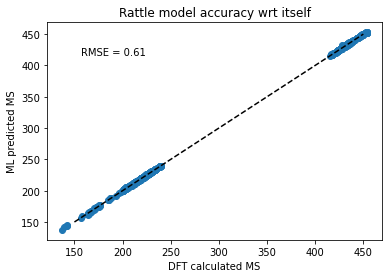

In [10]:
plt.scatter(target, predicted)
plt.plot([150,450],[150,450], color='black', linestyle='--')
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
rmse = round(rmse,2)
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Rattle model accuracy wrt itself')

In [13]:
o_tar_r, si_tar_r, o_pred_r, si_pred_r = species_splitter(target, predicted)

In [14]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_r
df1['O pred'] = o_pred_r
df1.to_csv('Rattle_O_wrt_self.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_r
df2['Si pred'] = si_pred_r
df2.to_csv('Rattle_Si_wrt_self.csv')

Text(0.5, 1.0, 'Rattle')

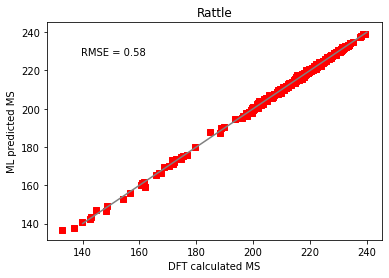

In [15]:
#O Rattle plots
plt.plot([140,240],[140,240], color='grey', linestyle='-')
plt.scatter(o_tar_r, o_pred_r, marker='s', color='red')
rmse = round(mean_squared_error(o_tar_r, o_pred_r, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Rattle')

Text(0.5, 1.0, 'Rattle')

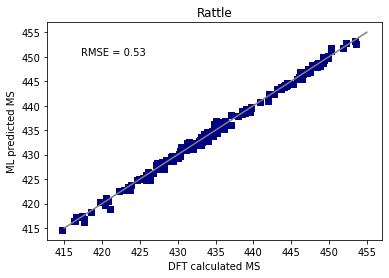

In [16]:
#Si Rattle plot
plt.scatter(si_tar_r, si_pred_r , marker='s', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_r, si_pred_r, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Rattle')

In [13]:
#HypoZeo
cut = 4
smo_cut = 0.5
sp_size = 1000
ker_exp = 25
reg = 1*10**-8

target, predicted, rmse = model_accuracy('HypoZeo', cut, smo_cut, sp_size, ker_exp, reg)
print(rmse)

1.2725319417716683


Text(0.5, 1.0, 'HypoZeo model accuracy wrt itself')

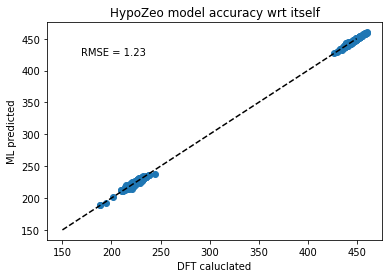

In [12]:
plt.scatter(target, predicted)
plt.plot([150,450],[150,450], color='black', linestyle='--')
plt.xlabel('DFT caluclated')
plt.ylabel('ML predicted')
rmse = round(rmse,2)
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('HypoZeo model accuracy wrt itself')

In [18]:
o_tar_h, si_tar_h, o_pred_h, si_pred_h = species_splitter(target, predicted)

In [19]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_h
df1['O pred'] = o_pred_h
df1.to_csv('HypoZeo_O_wrt_self.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_h
df2['Si pred'] = si_pred_h
df2.to_csv('HypoZeo_Si_wrt_self.csv')

Text(0.5, 1.0, 'Hypothetical Zeolite')

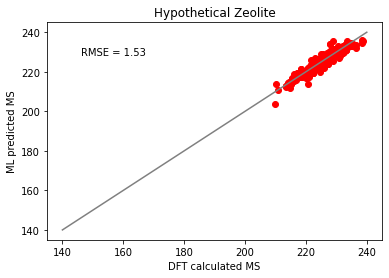

In [87]:
#O HypoZeo plot
plt.scatter(o_tar_h, o_pred_h, marker='o', color='red')
plt.plot([140,240],[140,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_h, o_pred_h, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Hypothetical Zeolite')

Text(0.5, 1.0, 'Hypothetical Zeolite')

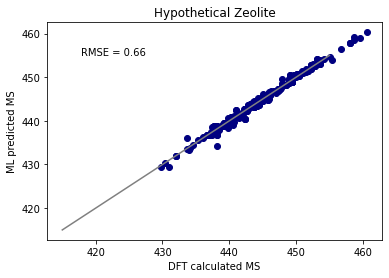

In [88]:
#Si HypoZeo plot
plt.scatter(si_tar_h, si_pred_h, marker='o', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_h, si_pred_h, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('Hypothetical Zeolite')

In [30]:
#AM0K
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 10
reg = 1*10**-5

target, predicted, rmse = model_accuracy('AM0K', cut, smo_cut, sp_size, ker_exp, reg)

Text(0.5, 1.0, 'AM0K model accuracy wrt itself')

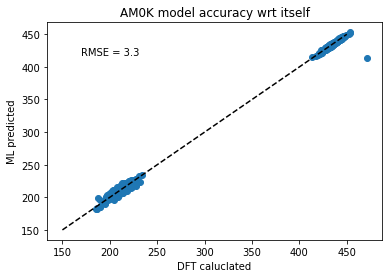

In [31]:
plt.scatter(target, predicted)
plt.plot([150,450],[150,450], color='black', linestyle='--')
plt.xlabel('DFT caluclated')
plt.ylabel('ML predicted')
rmse = round(rmse,2)
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM0K model accuracy wrt itself')

In [24]:
o_tar_a0, si_tar_a0, o_pred_a0, si_pred_a0 = species_splitter(target, predicted)

In [25]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_a0
df1['O pred'] = o_pred_a0
df1.to_csv('AM0K_O_wrt_self.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_a0
df2['Si pred'] = si_pred_a0
df2.to_csv('AM0K_Si_wrt_self.csv')

Text(0.5, 1.0, 'AM0K')

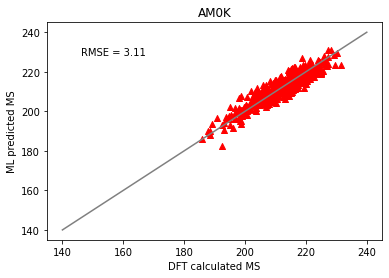

In [26]:
#O AM0K
plt.scatter(o_tar_a0, o_pred_a0, marker='^', color='red')
plt.plot([140,240],[140,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_a0, o_pred_a0, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM0K')

Text(0.5, 1.0, 'AM0K')

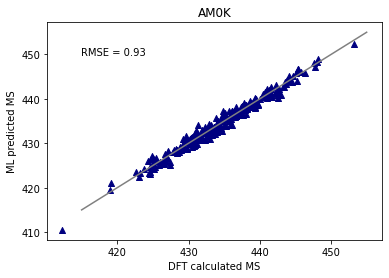

In [27]:
#Si AM0K
plt.scatter(si_tar_a0, si_pred_a0, marker='^', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_a0, si_pred_a0, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM0K')

In [23]:
#AM300K
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 10
reg = 1*10**-5

target, predicted, rmse = model_accuracy('AM300K', cut, smo_cut, sp_size, ker_exp, reg)

Text(0.5, 1.0, 'AM300K model accuracy wrt itself')

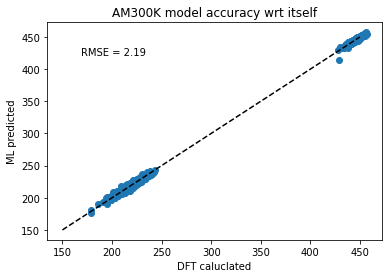

In [100]:
plt.scatter(target, predicted)
plt.plot([150,450],[150,450], color='black', linestyle='--')
plt.xlabel('DFT caluclated')
plt.ylabel('ML predicted')
rmse = round(rmse,2)
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM300K model accuracy wrt itself')

In [24]:
o_tar_a3, si_tar_a3, o_pred_a3, si_pred_a3 = species_splitter(target, predicted)

In [26]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_a3
df1['O pred'] = o_pred_a3
df1.to_csv('AM3K_O_wrt_self.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_a3
df2['Si pred'] = si_pred_a3
df2.to_csv('AM3K_Si_wrt_self.csv')

Text(0.5, 1.0, 'AM300K')

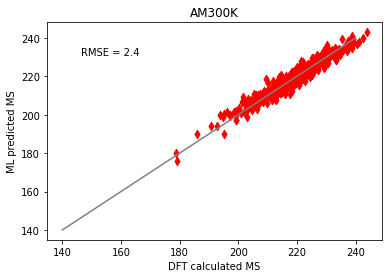

In [109]:
#O AM300K
plt.scatter(o_tar_a3, o_pred_a3, marker='d', color='red')
plt.plot([140,240],[140,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_a3, o_pred_a3, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM300K')

Text(0.5, 1.0, 'AM300K')

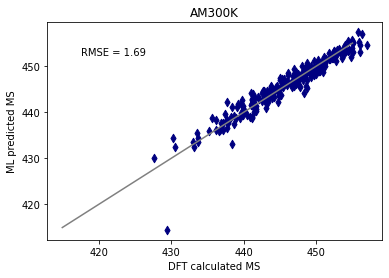

In [110]:
#Si AM300K
plt.scatter(si_tar_a3, si_pred_a3, marker='d', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_a3, si_pred_a3, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('AM300K')

In [27]:
#MD-Distorted
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 10
reg = 1*10**-5

target, predicted, rmse = model_accuracy('MD_Distorted', cut, smo_cut, sp_size, ker_exp, reg)

Text(0.5, 1.0, 'MD_Distorted model accuracy wrt itself')

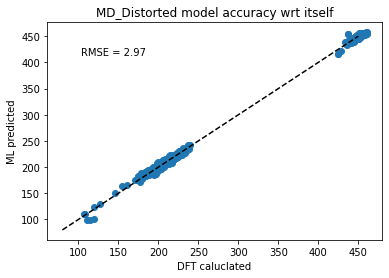

In [79]:
plt.scatter(target, predicted)
plt.plot([80,450],[80,450], color='black', linestyle='--')
plt.xlabel('DFT caluclated')
plt.ylabel('ML predicted')
rmse = round(rmse,2)
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('MD_Distorted model accuracy wrt itself')

In [28]:
o_tar_m, si_tar_m, o_pred_m, si_pred_m = species_splitter(target, predicted)

In [29]:
df1 = pd.DataFrame()
df1['O tar'] = o_tar_m
df1['O pred'] = o_pred_m
df1.to_csv('MD_O_wrt_self.csv')
df2 = pd.DataFrame()
df2['Si tar'] = si_tar_m
df2['Si pred'] = si_pred_m
df2.to_csv('MD_Si_wrt_self.csv')

Text(0.5, 1.0, 'MD')

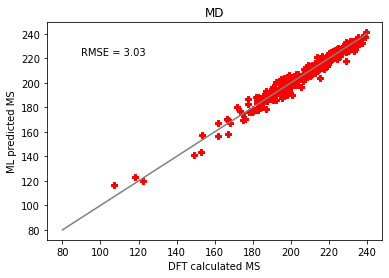

In [114]:
#O MD_Distorted
plt.scatter(o_tar_m, o_pred_m, marker='P', color='red')
plt.plot([80,240],[80,240], color='grey', linestyle='-')
rmse = round(mean_squared_error(o_tar_m, o_pred_m, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('MD')

Text(0.5, 1.0, 'MD')

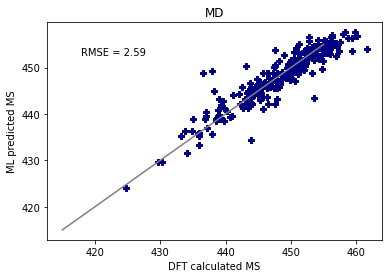

In [115]:
#Si MD_Distorted
plt.scatter(si_tar_m, si_pred_m, marker='P', color='navy')
plt.plot([415,455], [415,455], color='grey', linestyle='-')
rmse = round(mean_squared_error(si_tar_m, si_pred_m, squared=False),2)
plt.xlabel('DFT calculated MS')
plt.ylabel('ML predicted MS')
plt.annotate('RMSE = ' + str(rmse), xycoords='axes fraction', xy=(0.1,0.85))
plt.title('MD')